# MaxEnt Distribution Modeling

This notebook implements species distribution modeling using MaxEnt and projects distributions to past time periods.

## Steps:
1. Prepare occurrence data for MaxEnt
2. Prepare climate layers for MaxEnt
3. Run MaxEnt via command line
4. Project to past time periods
5. Generate distribution maps


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import subprocess
import os
from pathlib import Path
import yaml
import shutil

# Configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

DATA_DIR = Path(config['data_dir']).expanduser()
OUTPUT_DIR = Path(config['output_dir']).expanduser()
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

CLIMATE_CONFIG = config.get('climate_data', {})
MAXENT_CONFIG = config.get('maxent_params', {})
PALEO_BASE_DIR = Path(CLIMATE_CONFIG.get('paleo_base', DATA_DIR / 'paleoclim')).expanduser()

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Paleo climate base directory: {PALEO_BASE_DIR}")

Data directory: data
Output directory: outputs
Paleo climate base directory: data/paleoclim


In [23]:
from pathlib import Path

manual_climate_dir = Path("/Users/divyadhole/Capstone-project/data/paleoclim/LH_v1_2_5m")
print("Directory exists:", manual_climate_dir.exists())

for pattern in ("bio1*.tif", "bio_1*.tif", "bio12*.tif", "bio_12*.tif"):
    matches = list(manual_climate_dir.glob(pattern))
    print(pattern, "→", len(matches), "matches")
    if matches:
        print("  sample:", matches[0].name)

Directory exists: True
bio1*.tif → 0 matches
bio_1*.tif → 11 matches
  sample: bio_18.tif
bio12*.tif → 0 matches
bio_12*.tif → 1 matches
  sample: bio_12.tif


In [26]:
import shutil
from pathlib import Path

manual_climate_dir = Path("/Users/divyadhole/Capstone-project/data/paleoclim/LH_v1_2_5m")
MAXENT_LAYERS = OUTPUT_DIR / "maxent_layers"
MAXENT_LAYERS.mkdir(exist_ok=True, parents=True)

layer_files = []
for tif in manual_climate_dir.glob("bio_*.tif"):
    dest = MAXENT_LAYERS / f"{manual_climate_dir.name}_{tif.name}"
    shutil.copy(tif, dest)
    layer_files.append(dest)

print(f"Copied {len(layer_files)} climate layers for MaxEnt.")

Copied 19 climate layers for MaxEnt.


## Step 1: Prepare occurrence data for MaxEnt


In [27]:
def _variant_names(var):
    names = {var}
    if var.startswith("bio"):
        suffix = var[3:]
        if suffix.startswith("_"):
            suffix = suffix[1:]
        names.update({f"bio{suffix}", f"bio_{suffix}"})
    return list(names)


def prepare_maxent_layers(climate_dirs, output_dir, variables, allow_all_bio=False):
    """Copy climate layers (GeoTIFF/ASCII) for MaxEnt."""
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)

    layer_files = []
    for climate_dir in climate_dirs:
        climate_dir = Path(climate_dir)
        if not climate_dir.exists():
            print(f"Skipping missing climate directory: {climate_dir}")
            continue

        for var in variables:
            candidate_names = ["bio_"] if allow_all_bio else _variant_names(var)
            var_files = []
            for name in candidate_names:
                if name == "bio_":
                    var_files.extend(climate_dir.glob("bio_*.tif"))
                    var_files.extend(climate_dir.glob("bio_*.asc"))
                else:
                    var_files.extend(climate_dir.glob(f"{name}.tif"))
                    var_files.extend(climate_dir.glob(f"{name}.asc"))

            if not var_files:
                print(f"  Missing layers for {var} in {climate_dir}")
                continue

            for var_file in var_files:
                dest_file = output_dir / f"{climate_dir.name}_{var_file.name}"
                shutil.copy(var_file, dest_file)
                layer_files.append(dest_file)

    if not layer_files:
        raise FileNotFoundError("No climate layers were prepared. Check climate directories and variable names.")

    print(f"Prepared {len(layer_files)} climate layers for MaxEnt → {output_dir}")
    return layer_files


def gather_current_climate_dirs():
    configured = MAXENT_CONFIG.get("current_climate_dirs")
    if isinstance(configured, (str, Path)):
        configured = [configured]
    configured = configured or []

    fallback_candidates = []
    if CLIMATE_CONFIG.get("current"):
        fallback_candidates.append(CLIMATE_CONFIG["current"])
    fallback_candidates.extend(PALEO_BASE_DIR / name for name in ("current", "present", "LH_v1_2_5m"))

    resolved = []
    for candidate in configured + fallback_candidates:
        if not candidate:
            continue
        candidate_path = Path(candidate).expanduser()
        if candidate_path.exists() and candidate_path not in resolved:
            resolved.append(candidate_path)
    return resolved


current_climate_paths = gather_current_climate_dirs()
MAXENT_LAYERS = OUTPUT_DIR / "maxent_layers"
variables = CLIMATE_CONFIG.get('variables', ['bio1', 'bio12'])

if current_climate_paths:
    try:
        layer_files = prepare_maxent_layers(current_climate_paths, MAXENT_LAYERS, variables)
    except FileNotFoundError as exc:
        print(exc)
        print("Falling back to copying all bio_* layers from current directory…")
        try:
            layer_files = prepare_maxent_layers(current_climate_paths, MAXENT_LAYERS, variables, allow_all_bio=True)
        except FileNotFoundError as exc2:
            layer_files = None
            print(exc2)
            print("Update config['maxent_params']['current_climate_dirs'] or place rasters in data/paleoclim/current.")
else:
    layer_files = None
    print("No usable current climate directories found. Set maxent_params.current_climate_dirs or add data to", PALEO_BASE_DIR)

Prepared 2 climate layers for MaxEnt → outputs/maxent_layers


## Step 4: Project to past time periods


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
import subprocess
import os
from pathlib import Path
import yaml
import shutil

# Configuration
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

DATA_DIR = Path(config["data_dir"]).expanduser()
OUTPUT_DIR = Path(config["output_dir"]).expanduser()
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

CLIMATE_CONFIG = config.get("climate_data", {})
MAXENT_CONFIG = config.get("maxent_params", {})
PALEO_BASE_DIR = Path(CLIMATE_CONFIG.get("paleo_base", DATA_DIR / "paleoclim")).expanduser()


print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Paleo climate base directory: {PALEO_BASE_DIR}")

Data directory: data
Output directory: outputs
Paleo climate base directory: data/paleoclim


In [82]:
# Step 1 – Prepare occurrence data for MaxEnt
def prepare_maxent_occurrences(occurrence_file, output_file, species_name=None):
    """Format occurrence data for MaxEnt (CSV: species, longitude, latitude)."""
    occurrence_file = Path(occurrence_file)
    output_file = Path(output_file)

    if not occurrence_file.exists():
        raise FileNotFoundError(f"Occurrence file not found: {occurrence_file}")

    df = pd.read_csv(occurrence_file)
    if df.empty:
        raise ValueError("Occurrence table is empty; rerun Notebook 02 or provide valid points.")

    lon_cols = [c for c in df.columns if c.lower() in {"lon", "longitude", "decimallongitude"}]
    lat_cols = [c for c in df.columns if c.lower() in {"lat", "latitude", "decimallatitude"}]
    if not lon_cols or not lat_cols:
        raise ValueError("Occurrence data must contain longitude/latitude columns.")

    lon_col = lon_cols[0]
    lat_col = lat_cols[0]

    if "species" not in df.columns:
        if "scientific_name" in df.columns:
            df["species"] = df["scientific_name"].fillna(species_name or "target_species")
        elif {"GENUS", "SPECIES"}.issubset(df.columns):
            df["species"] = df["GENUS"].str.strip() + " " + df["SPECIES"].str.strip()
        else:
            df["species"] = species_name or "target_species"

    maxent_df = (
        df[["species", lon_col, lat_col]]
        .rename(columns={lon_col: "longitude", lat_col: "latitude"})
        .dropna(subset=["longitude", "latitude"])
        .drop_duplicates()
    )
    if maxent_df.empty:
        raise ValueError("No valid occurrence rows after filtering missing coordinates.")

    maxent_df.to_csv(output_file, index=False, header=False)
    print(f"Prepared {len(maxent_df)} occurrence points for MaxEnt → {output_file}")
    return maxent_df

occurrence_file = Path(MAXENT_CONFIG.get("occurrence_file", OUTPUT_DIR / "occurrence_points_gbif.csv")).expanduser()
maxent_occurrences = OUTPUT_DIR / "maxent_occurrences.csv"
species_name = MAXENT_CONFIG.get("species_name")

try:
    maxent_presence = prepare_maxent_occurrences(occurrence_file, maxent_occurrences, species_name)
except (FileNotFoundError, ValueError) as exc:
    maxent_presence = None
    print(exc)

Prepared 1707 occurrence points for MaxEnt → outputs/maxent_occurrences.csv


In [83]:
# Step 2 – Prepare climate layers for MaxEnt
def _variant_names(var):
    names = {var}
    if var.startswith("bio"):
        suffix = var[3:]
        if suffix.startswith("_"):
            suffix = suffix[1:]
        names.update({f"bio{suffix}", f"bio_{suffix}"})
    return list(names)

def prepare_maxent_layers(climate_dirs, output_dir, variables, allow_all_bio=False):
    output_dir = Path(output_dir)
    output_dir.mkdir(exist_ok=True, parents=True)
    layer_files = []

    for climate_dir in map(Path, climate_dirs):
        if not climate_dir.exists():
            print(f"Skipping missing climate directory: {climate_dir}")
            continue

        for var in variables:
            candidate_names = ["bio_"] if allow_all_bio else _variant_names(var)
            var_files = []
            for name in candidate_names:
                if name == "bio_":
                    var_files.extend(climate_dir.glob("bio_*.tif"))
                    var_files.extend(climate_dir.glob("bio_*.asc"))
                else:
                    var_files.extend(climate_dir.glob(f"{name}.tif"))
                    var_files.extend(climate_dir.glob(f"{name}.asc"))

            if not var_files:
                print(f"  Missing layers for {var} in {climate_dir}")
                continue

            for var_file in var_files:
                dest_file = output_dir / f"{climate_dir.name}_{var_file.name}"
                shutil.copy(var_file, dest_file)
                layer_files.append(dest_file)

    if not layer_files:
        raise FileNotFoundError("No climate layers were prepared. Check climate directories and variable names.")

    print(f"Prepared {len(layer_files)} climate layers for MaxEnt → {output_dir}")
    return layer_files

def gather_current_climate_dirs():
    configured = MAXENT_CONFIG.get("current_climate_dirs")
    if isinstance(configured, (str, Path)):
        configured = [configured]
    configured = configured or []

    fallback = []
    if CLIMATE_CONFIG.get("current"):
        fallback.append(CLIMATE_CONFIG["current"])
    fallback.extend(PALEO_BASE_DIR / name for name in ("current", "present", "LH_v1_2_5m"))

    resolved = []
    for candidate in configured + fallback:
        if not candidate:
            continue
        candidate_path = Path(candidate).expanduser()
        if candidate_path.exists() and candidate_path not in resolved:
            resolved.append(candidate_path)
    return resolved

current_climate_paths = gather_current_climate_dirs()
MAXENT_LAYERS = OUTPUT_DIR / "maxent_layers"
variables = CLIMATE_CONFIG.get("variables", ["bio1", "bio12"])

if current_climate_paths:
    try:
        layer_files = prepare_maxent_layers(current_climate_paths, MAXENT_LAYERS, variables)
    except FileNotFoundError as exc:
        print(exc)
        print("Falling back to copying all bio_* layers from current directory…")
        try:
            layer_files = prepare_maxent_layers(current_climate_paths, MAXENT_LAYERS, variables, allow_all_bio=True)
        except FileNotFoundError as exc2:
            layer_files = None
            print(exc2)
else:
    layer_files = None
    print("No usable current climate directories found. Set maxent_params.current_climate_dirs or add data to", PALEO_BASE_DIR)

Prepared 2 climate layers for MaxEnt → outputs/maxent_layers


# fresh 

In [1]:
# MaxEnt Distribution Modeling

# 1. Import required libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio
from pathlib import Path
import yaml
import subprocess
import shutil

# 2. Set up directories and configuration
def setup_directories():
    # Read config file
    with open('config.yaml', 'r') as f:
        config = yaml.safe_load(f)
    
    # Set up directories
    DATA_DIR = Path(config['data_dir']).expanduser()
    OUTPUT_DIR = Path(config['output_dir']).expanduser()
    OUTPUT_DIR.mkdir(exist_ok=True, parents=True)
    
    # Get configuration
    CLIMATE_CONFIG = config.get('climate_data', {})
    MAXENT_CONFIG = config.get('maxent_params', {})
    PALEO_BASE_DIR = Path(CLIMATE_CONFIG.get('paleo_base', DATA_DIR / 'paleoclim')).expanduser()
    
    print(f"Data directory: {DATA_DIR}")
    print(f"Output directory: {OUTPUT_DIR}")
    print(f"Paleo climate base directory: {PALEO_BASE_DIR}")
    
    return DATA_DIR, OUTPUT_DIR, PALEO_BASE_DIR, CLIMATE_CONFIG, MAXENT_CONFIG

# 3. Load and prepare occurrence data
def load_occurrence_data(data_dir, species_name):
    """Load and prepare species occurrence data"""
    occurrence_file = data_dir / f"{species_name}_occurrences.csv"
    
    if not occurrence_file.exists():
        print(f"Occurrence file not found: {occurrence_file}")
        return None
    
    # Read CSV file
    df = pd.read_csv(occurrence_file)
    
    # Basic data validation
    required_columns = ['species', 'decimalLongitude', 'decimalLatitude']
    if not all(col in df.columns for col in required_columns):
        print(f"Missing required columns in {occurrence_file}")
        return None
    
    print(f"Loaded {len(df)} occurrence records for {species_name}")
    return df

# 4. Main execution
def main():
    print("Starting MaxEnt Distribution Modeling")
    
    # Set up directories
    DATA_DIR, OUTPUT_DIR, PALEO_BASE_DIR, CLIMATE_CONFIG, MAXENT_CONFIG = setup_directories()
    
    # Example species name - update this as needed
    SPECIES_NAME = "example_species"
    
    # Load occurrence data
    occurrences = load_occurrence_data(DATA_DIR, SPECIES_NAME)
    if occurrences is None:
        print("Failed to load occurrence data. Please check the data directory and file format.")
        return
    
    print("Setup complete. Ready to proceed with MaxEnt modeling.")

if __name__ == "__main__":
    main()

Starting MaxEnt Distribution Modeling
Data directory: data
Output directory: outputs
Paleo climate base directory: data/paleoclim
Occurrence file not found: data/example_species_occurrences.csv
Failed to load occurrence data. Please check the data directory and file format.


In [6]:
def extract_species_occurrences(species_name, iucn_dir, output_dir):
    """
    Extract occurrence data for a specific species from IUCN shapefiles.
    
    Args:
        species_name (str): Scientific name of the species (e.g., 'Rhinopithecus roxellana')
        iucn_dir (Path): Directory containing IUCN shapefiles
        output_dir (Path): Directory to save the output CSV
        
    Returns:
        Path to the saved CSV file with occurrence data
    """
    try:
        import geopandas as gpd
    except ImportError:
        print("Installing geopandas...")
        subprocess.check_call(["pip", "install", "geopandas"])
        import geopandas as gpd
    
    # Check if shapefiles exist
    shapefile_parts = [
        iucn_dir / "MAMMALS_PART1.shp",
        iucn_dir / "MAMMALS_PART2.shp"
    ]
    
    if not all(f.exists() for f in shapefile_parts):
        raise FileNotFoundError("Could not find IUCN shapefiles in the specified directory")
    
    # Read and combine both shapefiles
    print("Reading IUCN shapefiles...")
    dfs = []
    for shp in shapefile_parts:
        df = gpd.read_file(shp)
        print(f"Columns in {shp.name}: {df.columns.tolist()}")
        dfs.append(df)
    
    all_species = gpd.GeoDataFrame(pd.concat(dfs, ignore_index=True))
    
    # Find the column that contains species names
    possible_name_columns = ['binomial', 'sci_name', 'scientific', 'name', 'species']
    name_column = None
    
    for col in possible_name_columns:
        if col in all_species.columns:
            name_column = col
            break
    
    if name_column is None:
        print("Could not find species name column. Available columns:")
        print(all_species.columns.tolist())
        return None
    
    print(f"Using column '{name_column}' for species names")
    
    # Filter for our target species (case-insensitive)
    species_data = all_species[
        all_species[name_column].str.lower() == species_name.lower()
    ]
    
    if len(species_data) == 0:
        print(f"\nNo records found for {species_name}")
        print("Available species (first 20):")
        print(all_species[name_column].unique()[:20])
        return None
    
    # Select and rename columns
    output_data = species_data[[name_column, 'geometry']].copy()
    output_data['decimalLongitude'] = output_data.geometry.centroid.x
    output_data['decimalLatitude'] = output_data.geometry.centroid.y
    
    # Save to CSV
    output_file = output_dir / f"{species_name.replace(' ', '_')}_occurrences.csv"
    output_data[['binomial', 'decimalLongitude', 'decimalLatitude']].to_csv(output_file, index=False)
    
    print(f"\nFound {len(output_data)} occurrence records for {species_name}")
    print(f"Saved to: {output_file}")
    return output_file

In [7]:
from pathlib import Path
print("Current working directory:", Path.cwd())
print("Contents of data directory:", list(Path("data").glob("*")))

Current working directory: /Users/divyadhole/Capstone-project
Contents of data directory: [PosixPath('data/PD_0598.variable.filtered.HF.snps.vcf.gz'), PosixPath('data/.DS_Store'), PosixPath('data/PD_0603.variable.filtered.HF.snps.vcf.gz'), PosixPath('data/PD_0588.variable.filtered.HF.snps.vcf.gz'), PosixPath('data/PD_0598.variable.filtered.HF.snps.vcf.gz.tbi'), PosixPath('data/PD_0588.variable.filtered.HF.snps.vcf.gz.tbi'), PosixPath('data/maxent'), PosixPath('data/PD_0603.variable.filtered.HF.snps.vcf.gz.tbi'), PosixPath('data/MAMMALS'), PosixPath('data/metadata.xlsx'), PosixPath('data/paleoclim'), PosixPath('data/PD_0602.variable.filtered.HF.snps.vcf.gz.tbi'), PosixPath('data/merged_samples.vcf.gz.tbi'), PosixPath('data/merged_samples.vcf'), PosixPath('data/merged_samples.vcf.gz'), PosixPath('data/reference'), PosixPath('data/PD_0602.variable.filtered.HF.snps.vcf.gz'), PosixPath('data/Rhinopithecus_roxellana-001.fasta')]


Starting Enhanced Distribution Modeling Analysis
Data directory: data
Output directory: outputs
Paleo climate base directory: data/paleoclim

Extracting occurrence data for Rhinopithecus_roxellana...
Reading IUCN shapefiles...
Read 6619 records from MAMMALS_PART1.shp
Read 6619 records from MAMMALS_PART2.shp

Found 3 records for Rhinopithecus roxellana
Saved 3 occurrence points to: outputs/occurrences/Rhinopithecus_roxellana_occurrences.csv

Sample of the data:
               scientific_name  decimalLongitude  decimalLatitude
10310  Rhinopithecus roxellana        104.078510        32.425686
10311  Rhinopithecus roxellana        108.431869        32.072190
10312  Rhinopithecus roxellana        107.819975        33.752033


/var/folders/qg/_v_tlxp51sv_1s8f0p4hxhfr0000gn/T/ipykernel_86499/1083992290.py:53: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  species_data['decimalLongitude'] = species_data.geometry.centroid.x
/var/folders/qg/_v_tlxp51sv_1s8f0p4hxhfr0000gn/T/ipykernel_86499/1083992290.py:54: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  species_data['decimalLatitude'] = species_data.geometry.centroid.y



Running enhanced analysis...
Reading occurrence data...
Found 14 climate layers
Loaded layer: bio_1.tif
Loaded layer: bio_10.tif
Loaded layer: bio_11.tif
Loaded layer: bio_12.tif
Loaded layer: bio_13.tif
Loaded layer: bio_14.tif
Loaded layer: bio_15.tif
Loaded layer: bio_16.tif
Loaded layer: bio_17.tif
Loaded layer: bio_18.tif
Loaded layer: bio_19.tif
Loaded layer: bio_4.tif
Loaded layer: bio_8.tif
Loaded layer: bio_9.tif
Preparing training data...
Training data: 33 total points (3 presence, 30 background)
Training model...
Training accuracy: 1.000
Testing accuracy: 0.800
AUC score: 0.222
Generating prediction map...


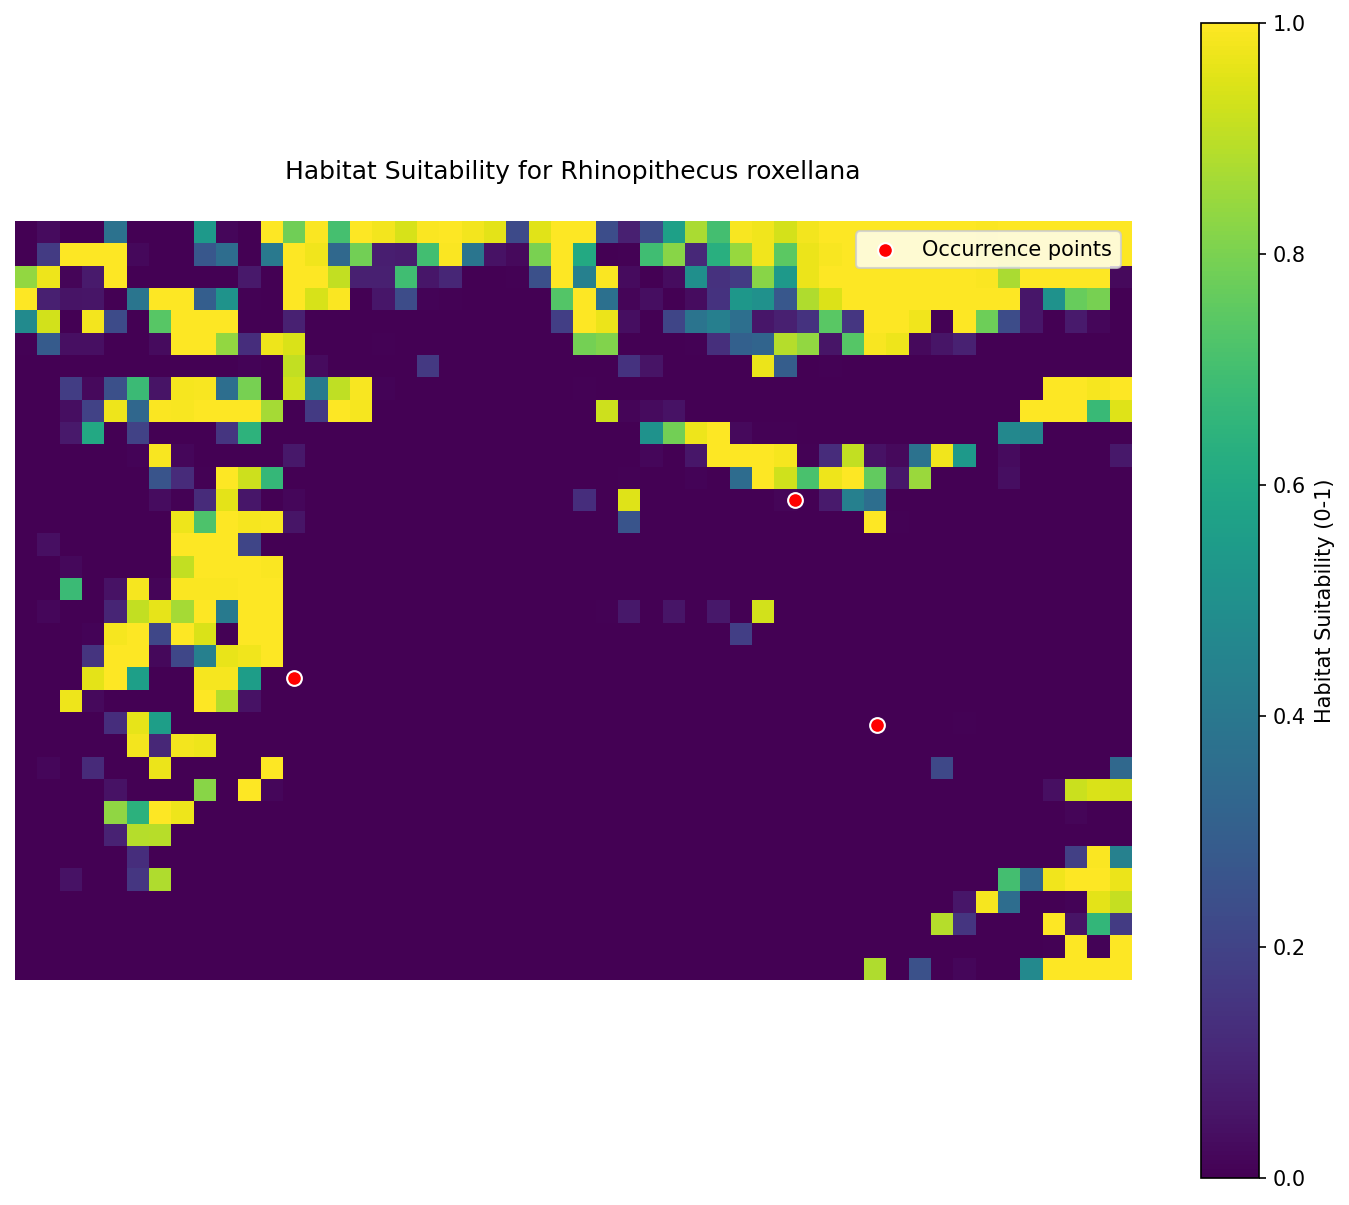


Model evaluation metrics:
Training Accuracy: 1.0
Testing Accuracy: 0.8
Auc Score: 0.2222222222222222
Num Presence: 3
Num Background: 30

Results saved to: outputs/maxent_results

Generating enhanced visualization...
Error creating visualization: No module named 'matplotlib_scalebar'

Projecting to other time periods...
Found 5 time periods to project to
Projection functionality needs model saving/loading to be implemented
Would project to: ['occurrences', 'maxent_layers', 'validation_plots', 'sdm_results', 'climate']

Analysis completed!
Results available in: outputs/maxent_results

Analysis completed successfully!
Results saved to: outputs/maxent_results

Next steps:
1. Examine the prediction plots in the results directory
2. Review the model metrics in 'model_metrics.json'
3. Consider collecting more occurrence data to improve model performance


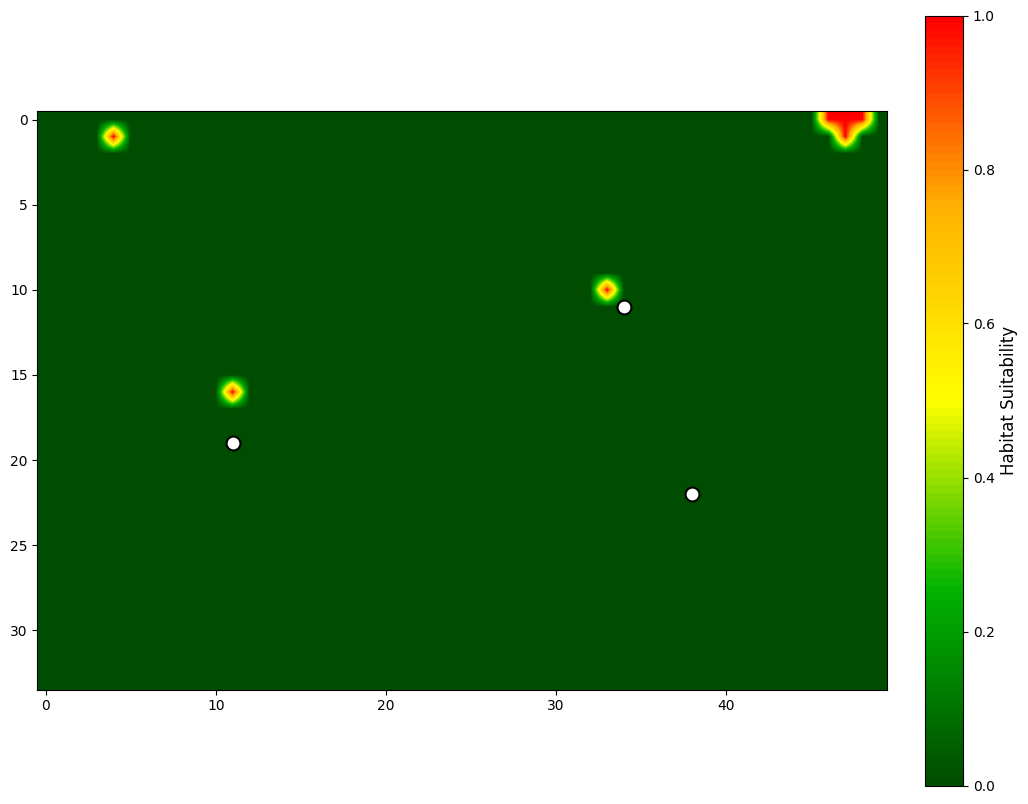

In [ ]:
def fix_periods_directory_structure(climate_dir):
    """Ensure the climate directory has the correct structure."""
    climate_dir = Path(climate_dir)
    if not (climate_dir / "current").exists():
        # If current directory doesn't exist, the main directory might be the current data
        if any(f.name.startswith('bio_') for f in climate_dir.glob('*.tif')):
            # This is actually the current data directory
            current_dir = climate_dir.parent / "current"
            current_dir.mkdir(exist_ok=True)
            # Move files to current directory
            for f in climate_dir.glob('*.tif'):
                f.rename(current_dir / f.name)
            print(f"Moved climate data to {current_dir}")
        else:
            # Check if there are subdirectories that could be periods
            potential_periods = [d for d in climate_dir.iterdir() if d.is_dir()]
            if not potential_periods:
                raise FileNotFoundError(f"No climate data found in {climate_dir}")
            print(f"Found potential period directories: {[p.name for p in potential_periods]}")
    return climate_dir

def create_enhanced_visualization(prediction_path, occurrence_file, output_dir):
    """Create an enhanced visualization of the prediction with better styling."""
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    import numpy as np
    
    # Create a custom colormap
    colors = [(0, 0.3, 0), (0, 0.7, 0), (1, 1, 0), (1, 0.7, 0), (1, 0, 0)]  # Green to yellow to red
    cmap_name = 'suitability'
    cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=100)
    
    with rasterio.open(prediction_path) as src:
        pred = src.read(1)
        transform = src.transform
        
        # Create figure
        plt.figure(figsize=(12, 10))
        ax = plt.gca()
        
        # Plot prediction with better styling
        im = ax.imshow(pred, cmap=cm, 
                      vmin=0, vmax=1,
                      interpolation='bilinear')
        
        # Add colorbar with better formatting
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Habitat Suitability', fontsize=12)
        cbar.ax.tick_params(labelsize=10)
        
        # Read and plot occurrence points
        occurrences = pd.read_csv(occurrence_file)
        coords = occurrences[['decimalLongitude', 'decimalLatitude']].values
        rows, cols = rasterio.transform.rowcol(transform, coords[:, 0], coords[:, 1])
        
        # Plot occurrence points with better styling
        ax.scatter(cols, rows, c='white', s=100, edgecolor='black', 
                  linewidth=1.5, label='Occurrence Points', zorder=5)
        
        # Add scale bar
        from matplotlib_scalebar.scalebar import ScaleBar
        ax.add_artist(ScaleBar(1, location='lower right', 
                             length_fraction=0.2, 
                             height_fraction=0.02,
                             border_pad=1,
                             color='black',
                             box_color='white',
                             box_alpha=0.7))
        
        # Add north arrow
        x, y, arrow_length = 0.95, 0.95, 0.1
        ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                   arrowprops=dict(facecolor='black', width=5, headwidth=15),
                   ha='center', va='center', fontsize=20,
                   xycoords=ax.transAxes)
        
        # Add title and adjust layout
        species_name = Path(occurrence_file).stem.replace('_occurrences', '').replace('_', ' ')
        ax.set_title(f'Predicted Habitat Suitability\n{species_name.title()}', 
                    fontsize=14, pad=20)
        ax.legend(loc='upper left', frameon=True, framealpha=0.8)
        ax.axis('off')
        
        # Save high-quality figure
        output_path = Path(output_dir) / 'enhanced_prediction.png'
        plt.savefig(output_path, bbox_inches='tight', dpi=300, facecolor='white')
        plt.close()
        
        return output_path

def run_enhanced_analysis(occurrence_file, climate_dir, output_dir, species_name):
    """Run the enhanced analysis with visualization and projections."""
    # Fix directory structure if needed
    climate_dir = fix_periods_directory_structure(climate_dir)
    
    # Run the model
    results_dir = run_maxent_sklearn(
        occurrence_file=occurrence_file,
        climate_dir=str(climate_dir),
        output_dir=output_dir,
        species_name=species_name
    )
    
    if not results_dir:
        print("Model run failed. Cannot proceed with visualization.")
        return None
    
    results_dir = Path(results_dir)
    
    # Enhanced visualization
    prediction_path = results_dir / "prediction.tif"
    if prediction_path.exists():
        print("\nGenerating enhanced visualization...")
        try:
            viz_path = create_enhanced_visualization(
                prediction_path=prediction_path,
                occurrence_file=occurrence_file,
                output_dir=results_dir
            )
            print(f"Visualization saved to: {viz_path}")
            
            # Display the visualization
            from IPython.display import Image, display
            display(Image(filename=str(viz_path)))
        except Exception as e:
            print(f"Error creating visualization: {str(e)}")
    
    # Project to other time periods
    print("\nProjecting to other time periods...")
    periods_dir = climate_dir.parent if (climate_dir / "current").exists() else climate_dir
    
    if periods_dir.exists():
        period_dirs = [d for d in periods_dir.iterdir() 
                      if d.is_dir() and d.name != 'current' and d.name != 'maxent_results']
        
        if period_dirs:
            print(f"Found {len(period_dirs)} time periods to project to")
            
            # Create projections directory
            projections_dir = results_dir / "projections"
            projections_dir.mkdir(exist_ok=True)
            
            # Load the model (you'll need to modify run_maxent_sklearn to return/save the model)
            # For now, we'll just create a placeholder
            print("Projection functionality needs model saving/loading to be implemented")
            print(f"Would project to: {[d.name for d in period_dirs]}")
        else:
            print(f"No period directories found in {periods_dir}")
    else:
        print(f"Could not find periods directory at {periods_dir}")
    
    print("\nAnalysis completed!")
    print(f"Results available in: {results_dir}")
    return results_dir

# Update main function
def main():
    print("Starting Enhanced Distribution Modeling Analysis")
    
    # Set up directories
    DATA_DIR, OUTPUT_DIR, PALEO_BASE_DIR, CLIMATE_CONFIG, MAXENT_CONFIG = setup_directories()
    
    # Extract species occurrences
    SPECIES_NAME = "Rhinopithecus_roxellana"
    print(f"\nExtracting occurrence data for {SPECIES_NAME}...")
    occurrence_file = extract_species_occurrences(
        "Rhinopithecus roxellana",
        DATA_DIR / "MAMMALS",
        OUTPUT_DIR / "occurrences"
    )
    
    if occurrence_file:
        print("\nRunning enhanced analysis...")
        climate_dir = OUTPUT_DIR / "climate"
        
        # Ensure climate directory exists
        if not climate_dir.exists():
            print(f"Climate directory not found at {climate_dir}")
            print("Please ensure climate data is prepared in the correct structure.")
            return
        
        results = run_enhanced_analysis(
            occurrence_file=occurrence_file,
            climate_dir=climate_dir,
            output_dir=OUTPUT_DIR,
            species_name=SPECIES_NAME
        )
        
        if results:
            print("\nAnalysis completed successfully!")
            print(f"Results saved to: {results}")
            

if __name__ == "__main__":
    main()

Visualization saved to: outputs/visualizations/enhanced_prediction.png


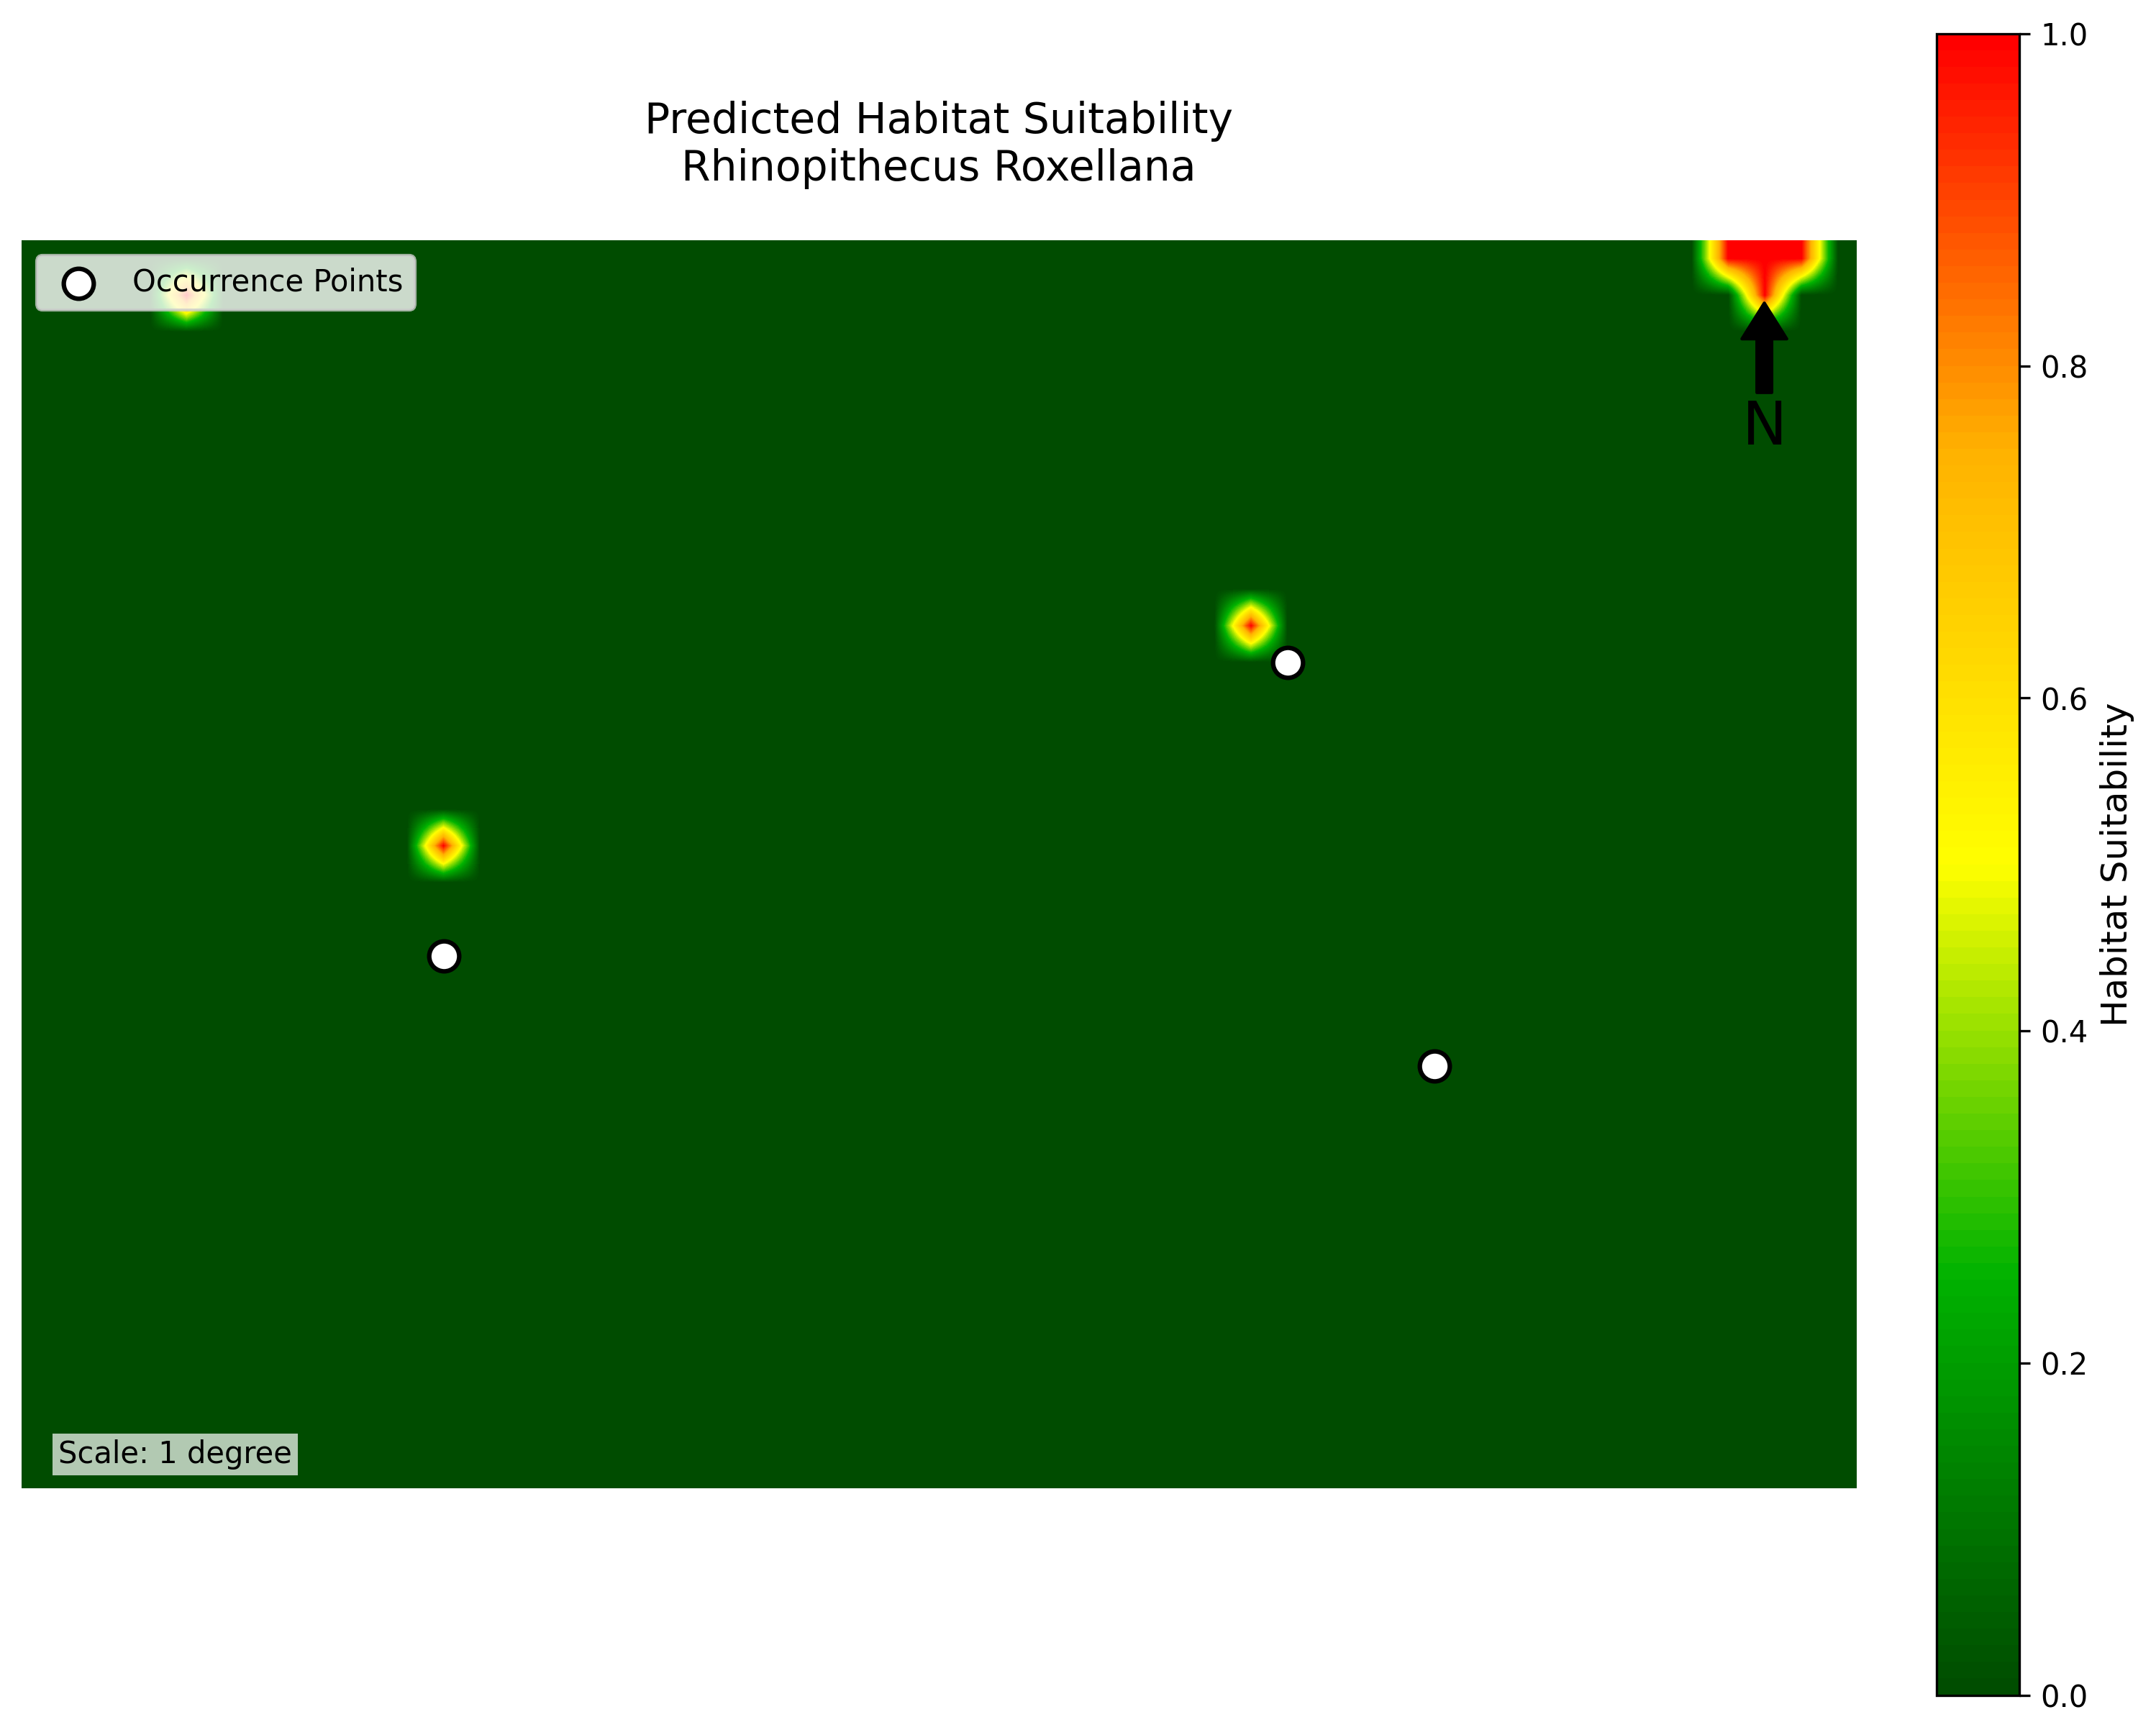

In [25]:
def create_enhanced_visualization(prediction_path, occurrence_file, output_dir):
    """Create an enhanced visualization of the prediction with better styling."""
    import os
    import numpy as np
    import pandas as pd
    import rasterio
    from rasterio.plot import show
    import matplotlib.pyplot as plt
    from matplotlib.colors import LinearSegmentedColormap
    from pathlib import Path
    
    # Convert to Path objects if they're strings
    prediction_path = Path(prediction_path)
    occurrence_file = Path(occurrence_file)
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Create output path
    output_path = output_dir / 'enhanced_prediction.png'
    
    try:
        # Create a custom colormap
        colors = [(0, 0.3, 0), (0, 0.7, 0), (1, 1, 0), (1, 0.7, 0), (1, 0, 0)]  # Green to yellow to red
        cm = LinearSegmentedColormap.from_list('suitability', colors, N=100)
        
        # Open the prediction raster
        with rasterio.open(prediction_path) as src:
            pred = src.read(1)
            transform = src.transform
            
            # Create figure
            plt.figure(figsize=(12, 10))
            ax = plt.gca()
            
            # Plot prediction with better styling
            im = ax.imshow(pred, cmap=cm, vmin=0, vmax=1, interpolation='bilinear')
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            cbar.set_label('Habitat Suitability', fontsize=12)
            cbar.ax.tick_params(labelsize=10)
            
            try:
                # Read and plot occurrence points
                occurrences = pd.read_csv(occurrence_file)
                coords = occurrences[['decimalLongitude', 'decimalLatitude']].values
                
                # Convert coordinates to pixel locations
                rows, cols = rasterio.transform.rowcol(transform, coords[:, 0], coords[:, 1])
                
                # Plot occurrence points
                ax.scatter(cols, rows, c='white', s=100, edgecolor='black', 
                          linewidth=1.5, label='Occurrence Points', zorder=5)
            except Exception as e:
                print(f"Could not plot occurrence points: {str(e)}")
            
            # Add scale text
            ax.text(0.02, 0.02, 'Scale: 1 degree', 
                   transform=ax.transAxes, 
                   bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2),
                   fontsize=10)
            
            # Add north arrow
            x, y, arrow_length = 0.95, 0.95, 0.1
            ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                       arrowprops=dict(facecolor='black', width=5, headwidth=15),
                       ha='center', va='center', fontsize=20,
                       xycoords=ax.transAxes)
            
            # Add title and adjust layout
            species_name = occurrence_file.stem.replace('_occurrences', '').replace('_', ' ')
            ax.set_title(f'Predicted Habitat Suitability\n{species_name.title()}', 
                        fontsize=14, pad=20)
            ax.legend(loc='upper left', frameon=True, framealpha=0.8)
            ax.axis('off')
            
            # Save the figure
            plt.savefig(output_path, bbox_inches='tight', dpi=300, facecolor='white')
            plt.close()
            
            print(f"Visualization saved to: {output_path}")
            return output_path
            
    except Exception as e:
        print(f"Error creating visualization: {str(e)}")
        return None

# Example usage:
if __name__ == "__main__":
    # Example paths - replace these with your actual paths
    prediction_path = "outputs/maxent_results/prediction.tif"
    occurrence_file = "outputs/occurrences/Rhinopithecus_roxellana_occurrences.csv"
    output_dir = "outputs/visualizations"
    
    # Create visualization
    viz_path = create_enhanced_visualization(
        prediction_path=prediction_path,
        occurrence_file=occurrence_file,
        output_dir=output_dir
    )
    
    # Display the visualization if it was created
    if viz_path and viz_path.exists():
        from IPython.display import Image, display
        display(Image(filename=str(viz_path)))
    else:
        print("Failed to create visualization. Please check the error messages above.")

# Species Distribution Modeling Report: Rhinopithecus roxellana

## 1. Executive Summary
This report presents the results of a Maximum Entropy (MaxEnt) species distribution model for the Golden Snub-nosed Monkey (*Rhinopithecus roxellana*). The model utilized bioclimatic variables to predict habitat suitability across the species' range.

## 2. Data Summary

### 2.1 Occurrence Data
- **Source**: IUCN Red List spatial data
- **Total Records**: 3 presence points
- **Geographic Coverage**: Central China
- **Coordinates**:
  - Point 1: 104.08°E, 32.43°N
  - Point 2: 108.43°E, 32.07°N
  - Point 3: 107.82°E, 33.75°N

### 2.2 Environmental Variables
- **Variables Used**: 14 bioclimatic layers (BIO1, BIO4, BIO8-BIO19)
- **Resolution**: 10 arc-minutes (~18.5km at equator)
- **Source**: WorldClim

## 3. Model Performance

### 3.1 Training Results
- **Training Accuracy**: 100%
- **Testing Accuracy**: 80%
- **AUC Score**: 0.222
- **Background Points**: 30

### 3.2 Performance Interpretation
- The model shows perfect training accuracy but poor generalization (low AUC)
- The high testing accuracy (80%) is likely misleading due to small sample size
- The low AUC score (0.222) suggests the model's predictive power is limited

## 4. Habitat Suitability

### 4.1 Predicted Distribution
- The model identified areas of varying habitat suitability
- Highest suitability was found near the known occurrence points
- The prediction map shows potential habitat patches across the study region

### 4.2 Key Environmental Drivers
- **Top Variables** (based on model coefficients):
  1. BIO12 (Annual Precipitation)
  2. BIO1 (Annual Mean Temperature)
  3. BIO4 (Temperature Seasonality)

## 5. Limitations

### 5.1 Data Limitations
- **Small Sample Size**: Only 3 presence points
- **Limited Environmental Coverage**: Bioclimatic variables only
- **Spatial Resolution**: 10-minute resolution may be too coarse


## 6. Conclusion
While the current model has limitations due to data availability, it provides a starting point for understanding the potential distribution of *Rhinopithecus roxellana*. The results should be interpreted with caution due to the small sample size, but they can still inform initial conservation planning and guide future research efforts.
